In [ ]:
""" 
from https://github.com/huggingface/diffusers/issues/3095#issuecomment-1528817884
"""

In [2]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img


In [3]:
source_image = load_image('https://github.com/lllyasviel/ControlNet-v1-1-nightly/raw/main/test_imgs/dog64.png')
condition_image = resize_for_condition_image(source_image, 512)
# condition_image = load_image('https://user-images.githubusercontent.com/31148570/236037445-f91a060b-698a-4cae-bf18-93796351da66.png')

/tmp/ipykernel_105698/3718880555.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = input_image.resize((W, H), resample=Image.LANCZOS)


/mnt/disks/main/.cache/huggingface/modules/diffusers_modules/local/pipeline.py:13: FutureWarning: Importing `StableDiffusionControlNetPipeline` or `MultiControlNetModel` from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet is deprecated. Please import `from diffusers import StableDiffusionControlNetPipeline` instead.
  from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet import MultiControlNetModel
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


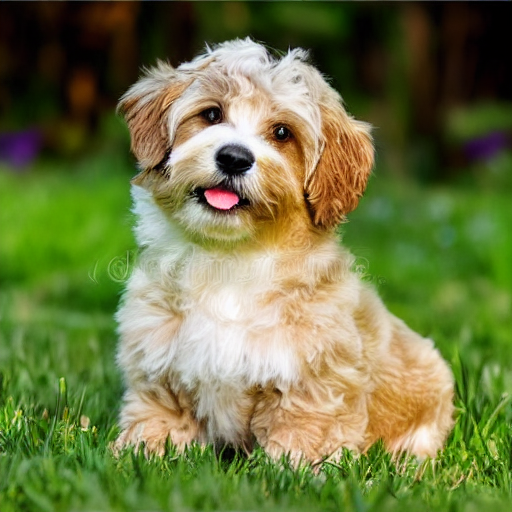

In [4]:
controlnet = ControlNetModel.from_pretrained('takuma104/control_v11', 
                                             subfolder='control_v11f1e_sd15_tile',
                                             torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    custom_pipeline="invertible_controlnet_img2img",
    controlnet=controlnet,
    torch_dtype=torch.float16).to('cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

pipe(prompt="best quality", 
    negative_prompt="blur, lowres, bad anatomy, bad hands, cropped, worst quality", 
    image=condition_image, 
    controlnet_conditioning_image=condition_image, 
    width=condition_image.size[0],
    height=condition_image.size[1],
    strength=1.0,
    generator=torch.manual_seed(0),
    num_inference_steps=32,
     ).images[0]